# Datenexploration für Schlafqualität-Vorhersage

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()


## 1. Laden und Überblick des Datensatzes

In [4]:
# Daten laden
df = pd.read_csv('/Users/tommygrace/Desktop/Code/schlafqualitaet_vorhersage/data/sleep_health_metrics.csv')
print(df.head())

# Informationen über den Datensatz
print("\nDatensatzinformationen:")
print(df.info())

# Überprüfung auf fehlende Werte
print("\nFehlende Werte:")
print(df.isnull().sum())

# Gedanken: Es ist wichtig zu überprüfen, ob es fehlende Werte gibt und wie wir damit umgehen sollten.

   Heart_Rate_Variability  Body_Temperature  Movement_During_Sleep  \
0               79.934283         37.199678               1.324822   
1               67.234714         36.962317               1.855481   
2               82.953771         36.529815               1.207580   
3              100.460597         36.176532               1.692038   
4               65.316933         36.849112               0.106385   

   Sleep_Duration_Hours  Sleep_Quality_Score  Caffeine_Intake_mg  \
0              4.638289                  1.0          107.624032   
1              6.209422                  1.0          104.658589   
2              6.879592                 10.0            0.000000   
3             10.331531                  1.0          116.990981   
4              8.334830                  1.0          223.282908   

   Stress_Level  Bedtime_Consistency  Light_Exposure_hours  
0      2.771837             0.657037              7.933949  
1      3.738138             0.144464            

## 2. Statistische Zusammenfassung

In [5]:
# Grundlegende statistische Informationen
print(df.describe())

# Gedanken: Die statistische Zusammenfassung gibt uns einen ersten Einblick in die Verteilung der Daten.
# Wir sollten auf Ausreißer und ungewöhnliche Werte achten.

       Heart_Rate_Variability  Body_Temperature  Movement_During_Sleep  \
count             1000.000000       1000.000000            1000.000000   
mean                70.386641         36.535418               2.005834   
std                 19.584319          0.498727               0.983454   
min                  5.174653         35.029806              -1.019512   
25%                 57.048194         36.196879               1.352000   
50%                 70.506012         36.531539               1.999749   
75%                 82.958878         36.864441               2.660915   
max                147.054630         38.096554               5.926238   

       Sleep_Duration_Hours  Sleep_Quality_Score  Caffeine_Intake_mg  \
count           1000.000000          1000.000000         1000.000000   
mean               7.471921             2.592946          148.260148   
std                1.540699             2.979500           94.031760   
min                3.105827             1.000

## 3. Visualisierung der Verteilungen

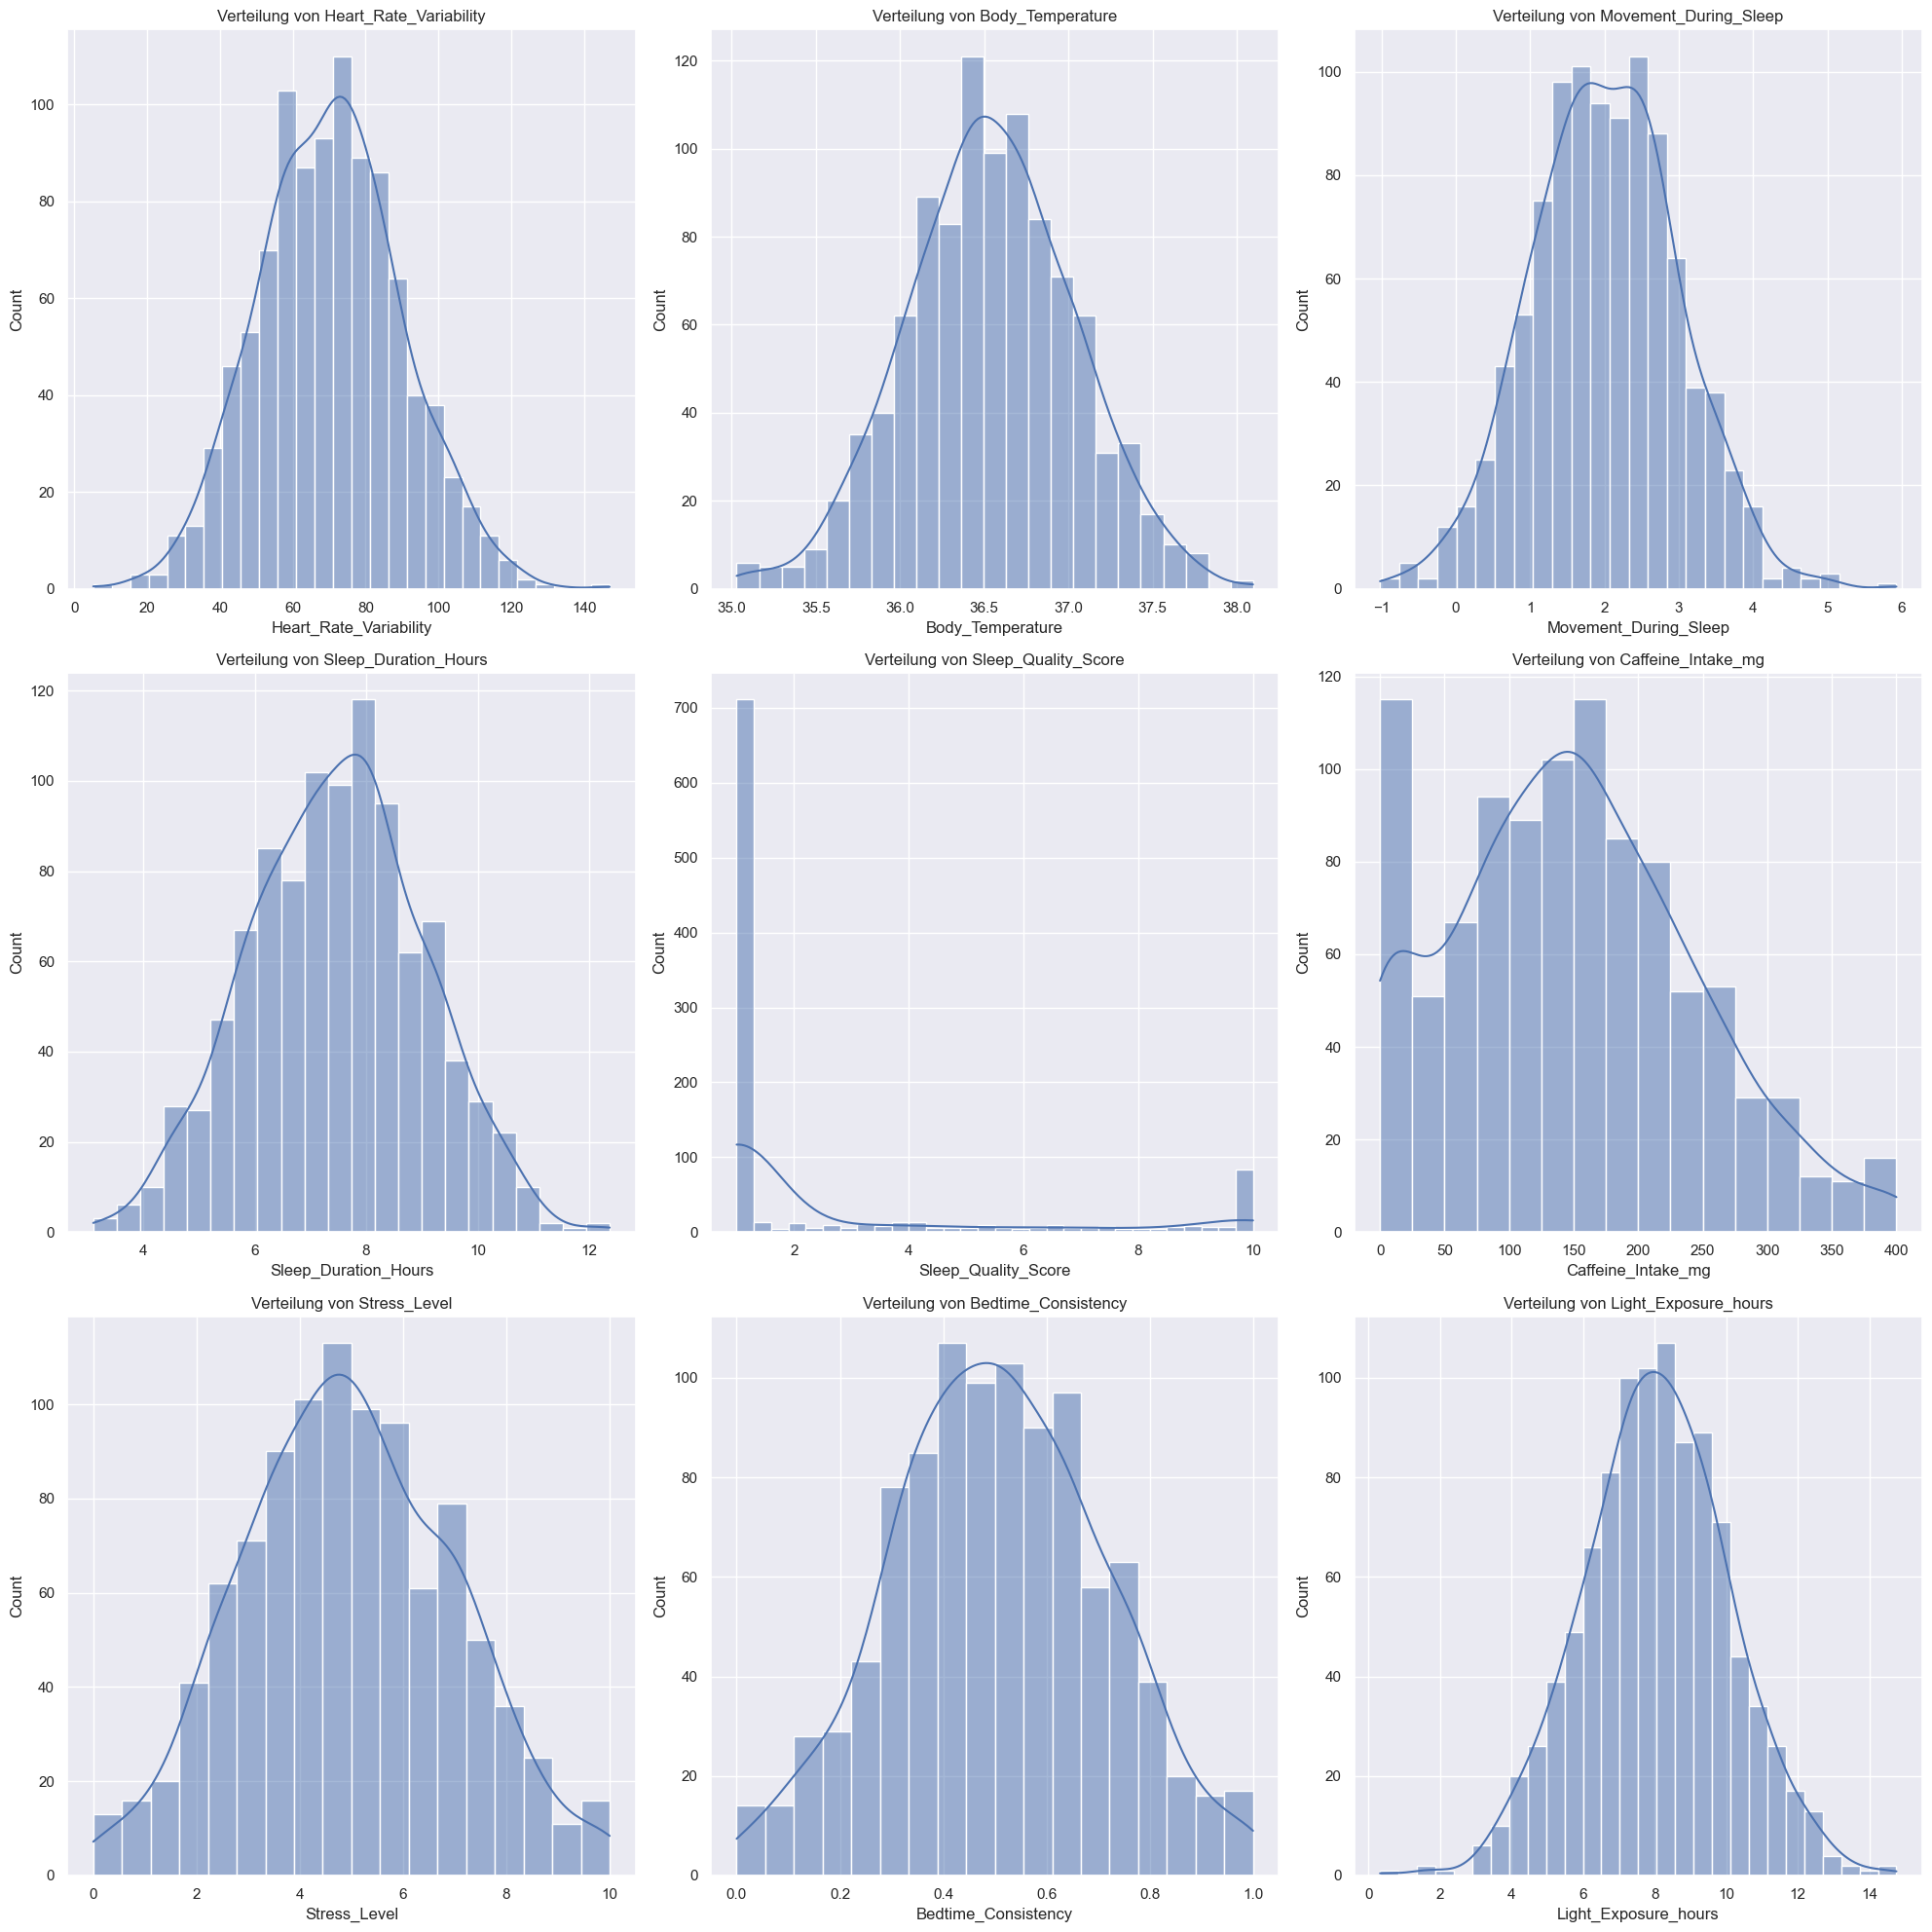

In [6]:
# Histogramme für numerische Variablen
numeric_columns = df.select_dtypes(include=[np.number]).columns
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.histplot(data=df, x=col, kde=True, ax=axes[i])
    axes[i].set_title(f'Verteilung von {col}')

plt.tight_layout()
plt.show()

# Gedanken: Die Verteilungen helfen uns, Ausreißer zu identifizieren und zu verstehen,
# ob Transformationen der Daten notwendig sein könnten.

## 4. Korrelationsanalyse

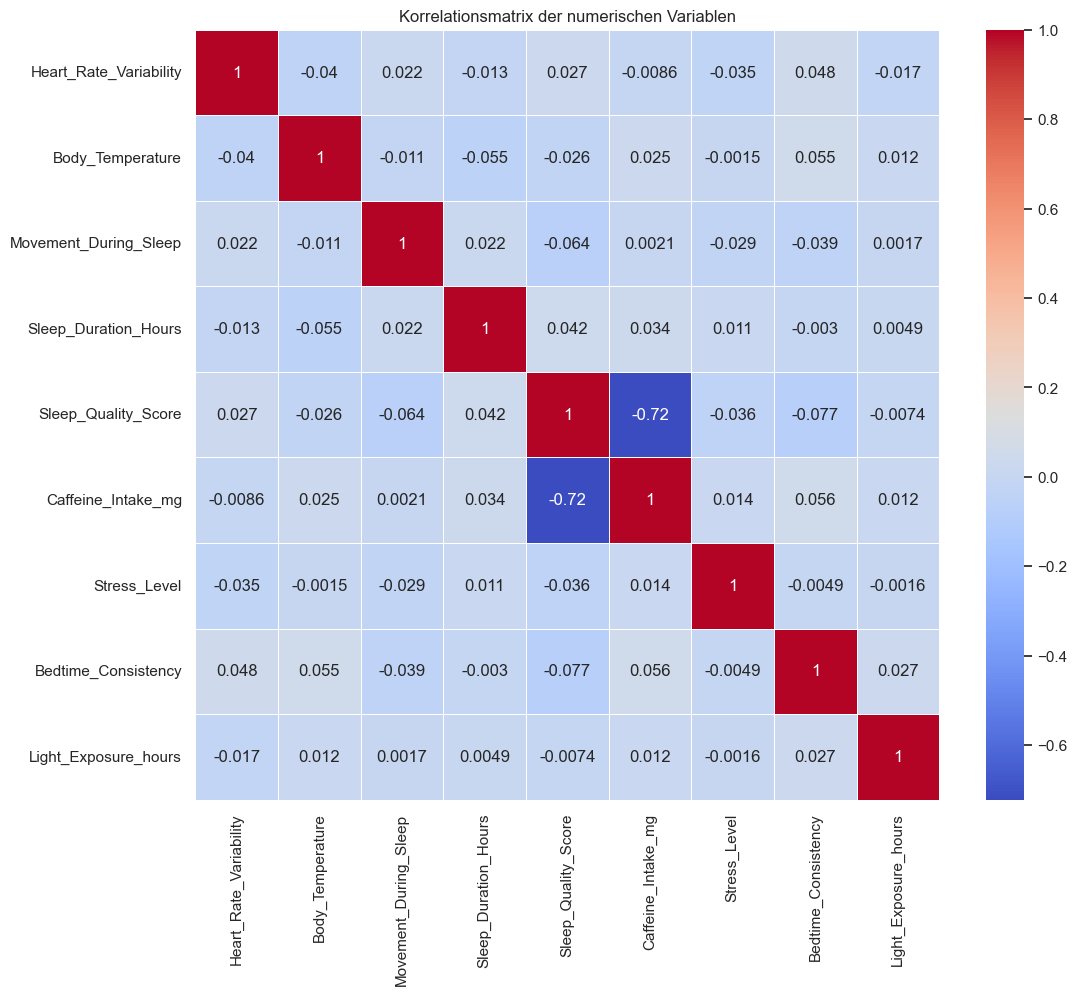

In [7]:
# Korrelationsmatrix
plt.figure(figsize=(12, 10))
sns.heatmap(df[numeric_columns].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Korrelationsmatrix der numerischen Variablen')
plt.show()

# Gedanken: Die Korrelationsmatrix hilft uns, Beziehungen zwischen den Variablen zu erkennen.
# Starke Korrelationen könnten auf Multikollinearität hinweisen, was bei der Modellierung berücksichtigt werden sollte.

## 5. Identifizierung möglicher Ausreißer

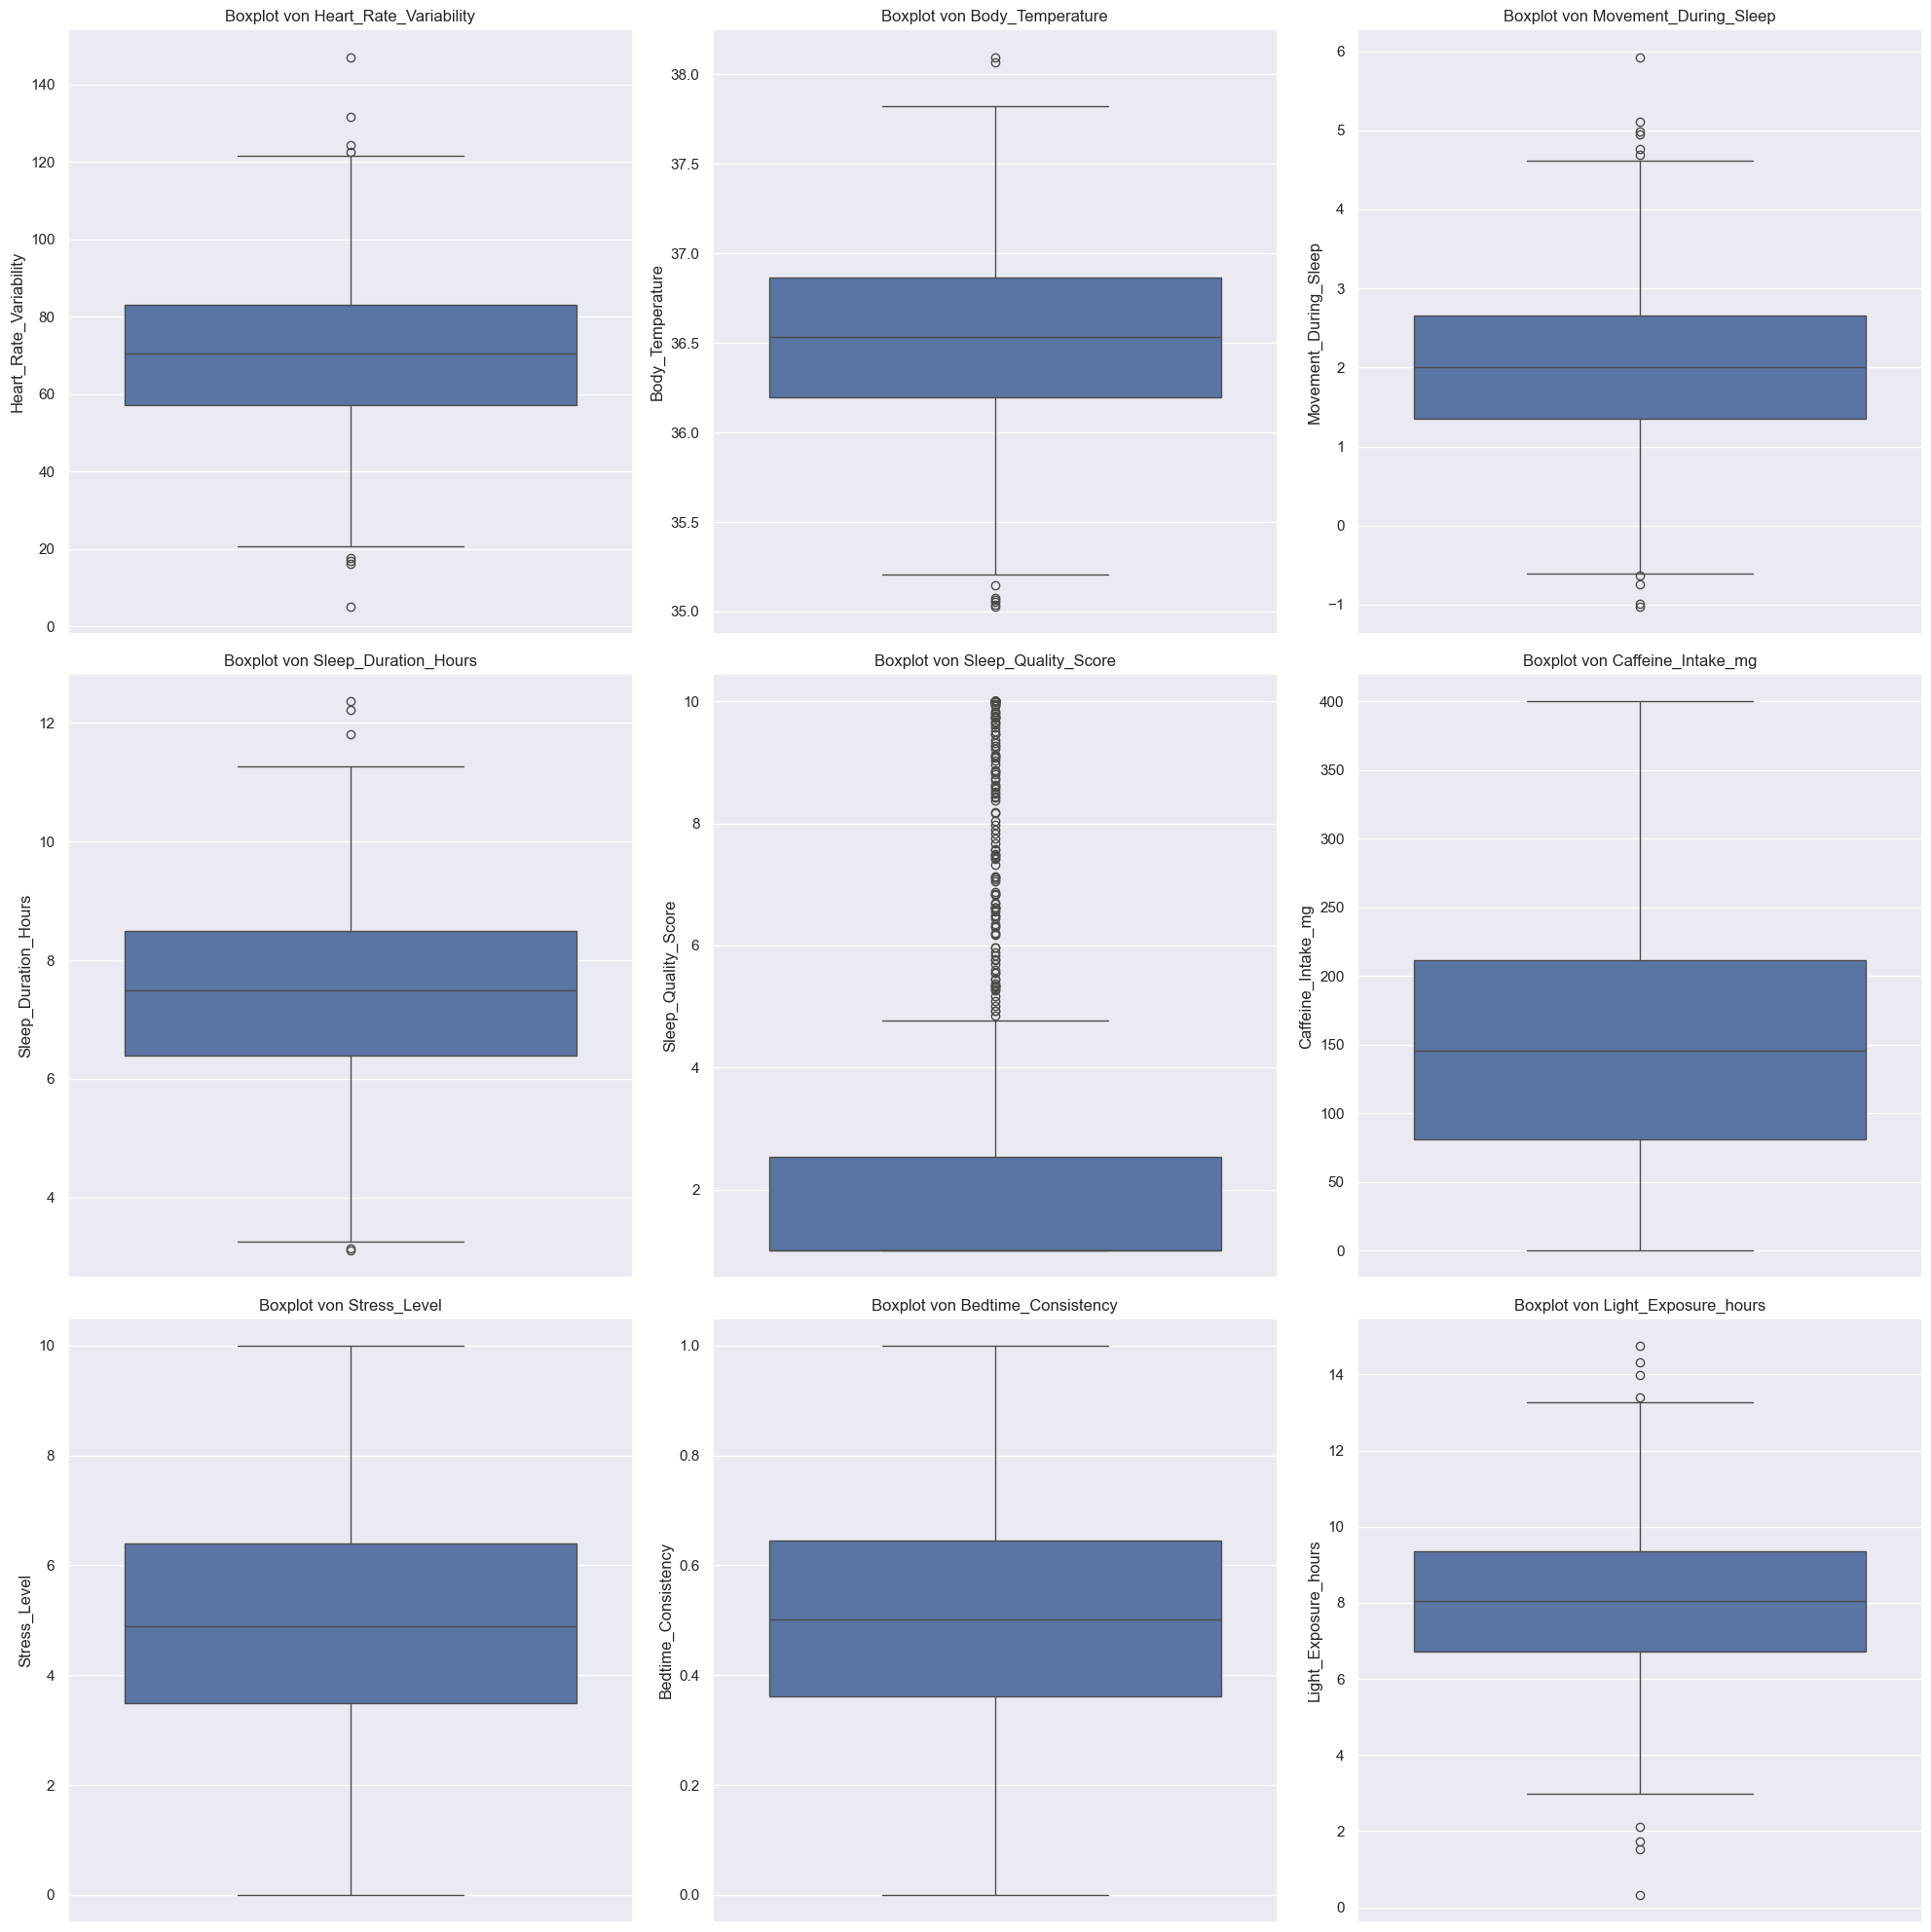

In [8]:
# Boxplots für numerische Variablen
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.boxplot(data=df, y=col, ax=axes[i])
    axes[i].set_title(f'Boxplot von {col}')

plt.tight_layout()
plt.show()

# Gedanken: Boxplots sind nützlich, um Ausreißer visuell zu identifizieren.
# Wir sollten überlegen, wie wir mit diesen Ausreißern umgehen wollen (z.B. entfernen, transformieren oder beibehalten).

## 6. Zusammenfassung und nächste Schritte

Basierend auf unserer Datenexploration können wir folgende Schlüsse ziehen und nächste Schritte planen:

1. Datenqualität: Überprüfen Sie, ob fehlende Werte behandelt werden müssen.
2. Ausreißer: Identifizieren Sie signifikante Ausreißer und entscheiden Sie, wie damit umzugehen ist.
3. Verteilungen: Betrachten Sie, ob Datentransformationen (z.B. Log-Transformation) für schiefe Verteilungen sinnvoll sind.
4. Korrelationen: Berücksichtigen Sie starke Korrelationen bei der Modellauswahl und -entwicklung.
5. Feature Engineering: Überlegen Sie, ob neue Features aus den vorhandenen Daten erstellt werden können.
6. Kategorische Variablen: Führen Sie eine detailliertere Analyse der kategorischen Variablen durch (z.B. Häufigkeitsverteilungen).

Der nächste Schritt könnte die Datenvorbereitung sein, gefolgt von der Auswahl und dem Training eines geeigneten Modells zur Vorhersage der Schlafqualität.

In [14]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# 1. Funktionen zur Behandlung von Ausreißern

def identify_outliers(df, column, method='iqr'):
    if method == 'iqr':
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    elif method == 'zscore':
        z_scores = stats.zscore(df[column])
        return df[abs(z_scores) > 3]

def treat_outliers(df, column, method='cap'):
    outliers = identify_outliers(df, column)
    if method == 'cap':
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[column] = df[column].clip(lower_bound, upper_bound)
    elif method == 'remove':
        df = df[~df.index.isin(outliers.index)]
    return df

# Anwendung auf alle numerischen Spalten
numeric_columns = df.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    df = treat_outliers(df, col, method='cap')

    

In [15]:
# 2. Datentransformationen
standard_scale_cols = ['Heart_Rate_Variability', 'Movement_During_Sleep']
minmax_scale_cols = ['Sleep_Duration_Hours', 'Caffeine_Intake_mg']

df[standard_scale_cols] = StandardScaler().fit_transform(df[standard_scale_cols])
df[minmax_scale_cols] = MinMaxScaler().fit_transform(df[minmax_scale_cols])

# 3. Feature Engineering
# Kategorisierung der Schlafqualität
df['Sleep_Quality_Group'] = pd.cut(df['Sleep_Quality_Score'], bins=3, labels=['Low', 'Medium', 'High'])

# Interaktionsterme
df['Caffeine_Stress_Interaction'] = df['Caffeine_Intake_mg'] * df['Stress_Level']

# Binäre Features
df['High_Caffeine'] = (df['Caffeine_Intake_mg'] > df['Caffeine_Intake_mg'].mean()).astype(int)

# Zeitbasierte Features (falls vorhanden)
if 'Bedtime' in df.columns:
    df['Bedtime_Hour'] = pd.to_datetime(df['Bedtime']).dt.hour

# Aggregierte Features (falls mehrere Einträge pro Person vorhanden sind)
if 'Person_ID' in df.columns:
    df['Avg_Sleep_Duration'] = df.groupby('Person_ID')['Sleep_Duration_Hours'].transform('mean')

# Polynomiale Features
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[['Stress_Level', 'Caffeine_Intake_mg']])

# Verwenden Sie get_feature_names_out() statt get_feature_names()
feature_names = poly.get_feature_names_out(['Stress_Level', 'Caffeine_Intake_mg'])
poly_features_df = pd.DataFrame(poly_features, columns=feature_names)
df = pd.concat([df, poly_features_df], axis=1)

# Überprüfen der Ergebnisse
print(df.head())
print(df.columns)

   Heart_Rate_Variability  Body_Temperature  Movement_During_Sleep  \
0                0.493140         37.199678              -0.698880   
1               -0.161326         36.962317              -0.152911   
2                0.648748         36.529815              -0.819504   
3                1.550954         36.176532              -0.321069   
4               -0.260158         36.849112              -1.952467   

   Sleep_Duration_Hours  Sleep_Quality_Score  Caffeine_Intake_mg  \
0              0.166652             1.000000            0.269060   
1              0.353110             1.000000            0.261646   
2              0.432644             4.844473            0.000000   
3              0.842312             1.000000            0.292477   
4              0.605348             1.000000            0.558207   

   Stress_Level  Bedtime_Consistency  Light_Exposure_hours  \
0      2.771837             0.657037              7.933949   
1      3.738138             0.144464          

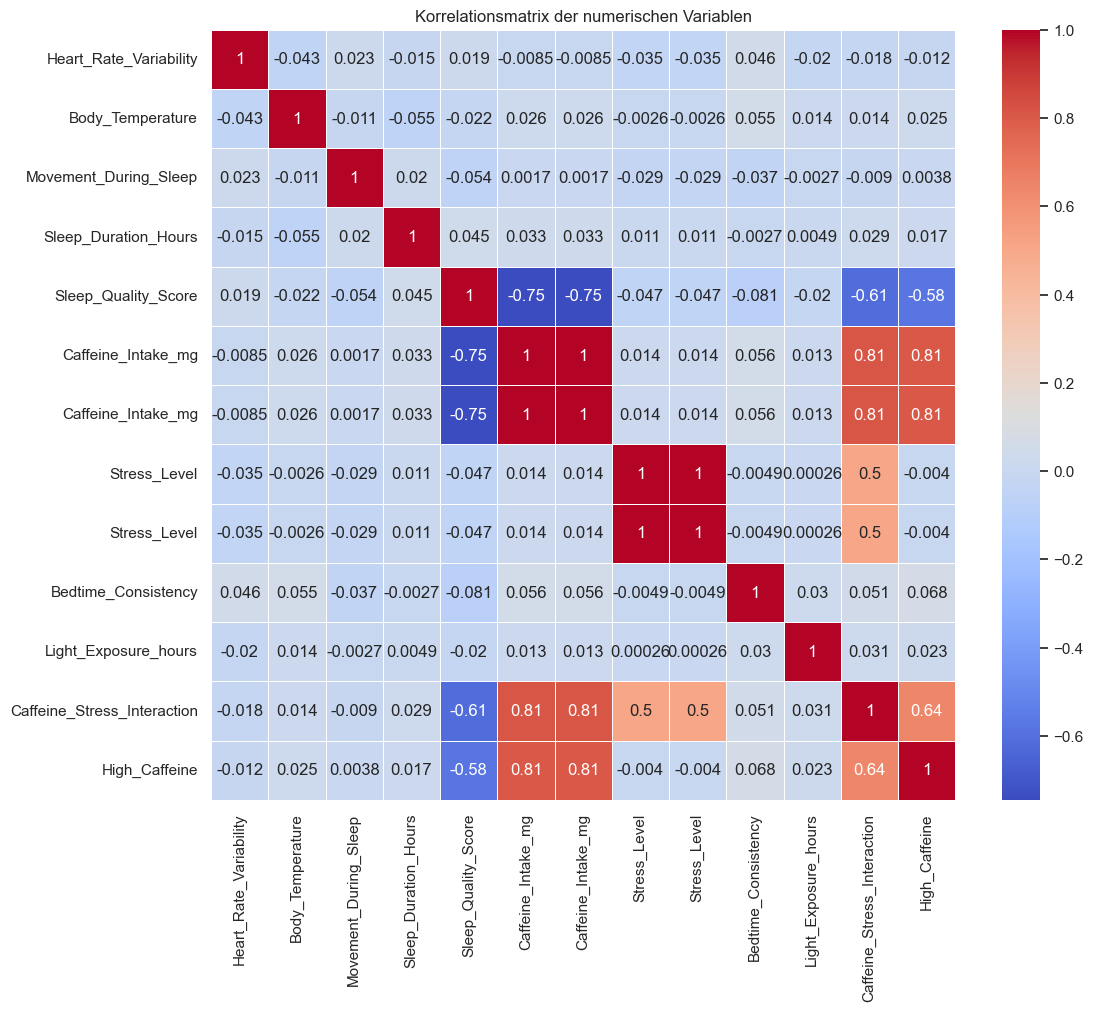

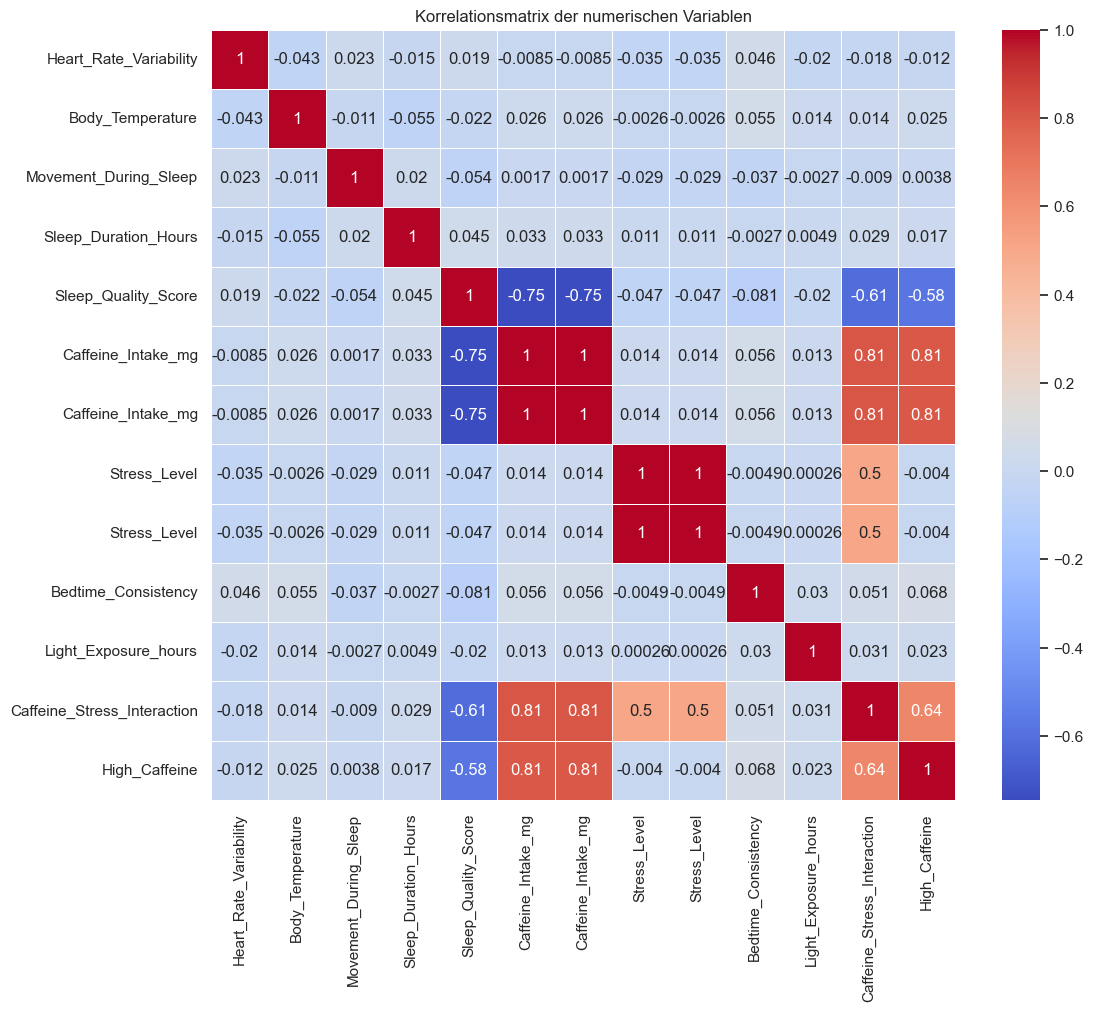

Starke Korrelationen (|r| > 0.5):
Sleep_Quality_Score - Caffeine_Intake_mg: -0.75
Sleep_Quality_Score - Caffeine_Intake_mg: -0.75
Sleep_Quality_Score - Caffeine_Stress_Interaction: -0.61
Sleep_Quality_Score - High_Caffeine: -0.58
Caffeine_Intake_mg - Caffeine_Intake_mg: 1.00
Caffeine_Intake_mg - Caffeine_Stress_Interaction: 0.81
Caffeine_Intake_mg - High_Caffeine: 0.81
Caffeine_Intake_mg - Caffeine_Stress_Interaction: 0.81
Caffeine_Intake_mg - High_Caffeine: 0.81
Stress_Level - Stress_Level: 1.00
Stress_Level - Caffeine_Stress_Interaction: 0.50
Stress_Level - Caffeine_Stress_Interaction: 0.50
Caffeine_Stress_Interaction - High_Caffeine: 0.64


In [18]:
 # Korrelationsmatrix                                                                                                                                                                                                                                                                                     
 plt.figure(figsize=(12, 10))                                                                                                                                                                                                                                                                             
 sns.heatmap(df[numeric_columns].corr(), annot=True, cmap='coolwarm', linewidths=0.5)                                                                                                                                                                                                                     
 plt.title('Korrelationsmatrix der numerischen Variablen')                                                                                                                                                                                                                                                
 plt.show()                                                                                                                                                                                                                                                                                               
                                                                                                                                                                                                                                                                                                          
 # Gedanken: Die Korrelationsmatrix hilft uns, Beziehungen zwischen den Variablen zu erkennen.                                                                                                                                                                                                            
 # Starke Korrelationen könnten auf Multikollinearität hinweisen, was bei der Modellierung berücksichtigt werden sollte.                                                                                                                                                                                  
 # =======                                                                                                                                                                                                                                                                                                  
 ## 4. Detaillierte Korrelationsanalyse                                                                                                                                                                                                                                                                   
                                                                                                                                                                                                                                                                                                          
 # Korrelationsmatrix                                                                                                                                                                                                                                                                                     
 plt.figure(figsize=(12, 10))                                                                                                                                                                                                                                                                             
 corr_matrix = df[numeric_columns].corr()                                                                                                                                                                                                                                                                 
 sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)                                                                                                                                                                                                                                    
 plt.title('Korrelationsmatrix der numerischen Variablen')                                                                                                                                                                                                                                                
 plt.show()                                                                                                                                                                                                                                                                                               
                                                                                                                                                                                                                                                                                                          
 # Identifizierung starker Korrelationen                                                                                                                                                                                                                                                                  
 strong_correlations = np.where(np.abs(corr_matrix) > 0.5)                                                                                                                                                                                                                                                
 strong_correlations = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y])                                                                                                                                                                                                            
                        for x, y in zip(*strong_correlations) if x != y and x < y]                                                                                                                                                                                                                        
                                                                                                                                                                                                                                                                                                          
 print("Starke Korrelationen (|r| > 0.5):")                                                                                                                                                                                                                                                               
 for var1, var2, corr in strong_correlations:                                                                                                                                                                                                                                                             
     print(f"{var1} - {var2}: {corr:.2f}")                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                                                                                          
 # Gedanken:                                                                                                                                                                                                                                                                                              
 # 1. Die Korrelationsmatrix hilft uns, Beziehungen zwischen den Variablen zu erkennen.                                                                                                                                                                                                                   
 # 2. Starke Korrelationen könnten auf Multikollinearität hinweisen, was bei der Modellierung berücksichtigt werden sollte.                                                                                                                                                                               
 # 3. Besonders starke Korrelationen (positiv oder negativ) sollten genauer untersucht werden.  

In [23]:
import os
import pandas as pd
import numpy as np

# Angenommen, Ihr aktueller DataFrame heißt 'df'

# Fügen Sie einige der fehlenden Features hinzu
df['Sleep_Quality_Group'] = pd.cut(df['Sleep_Quality_Score'], 
                                   bins=[0, 3, 6, 10], 
                                   labels=['Low', 'Medium', 'High'])

df['Caffeine_Stress_Interaction'] = df['Caffeine_Intake_mg'] * df['Stress_Level']

df['High_Caffeine'] = (df['Caffeine_Intake_mg'] > df['Caffeine_Intake_mg'].median()).astype(int)

df['Stress_Level^2'] = df['Stress_Level'] ** 2
df['Caffeine_Intake_mg^2'] = df['Caffeine_Intake_mg'] ** 2

# Definieren Sie den Pfad zum data Ordner
data_path = os.path.join('..', 'data')

# Überprüfen Sie, ob der Ordner existiert
if not os.path.exists(data_path):
    os.makedirs(data_path)

# Speichern Sie den DataFrame als CSV
csv_path = os.path.join(data_path, 'cleaned_sleep_health_metrics.csv')
df.to_csv(csv_path, index=False)

print(f"Die bereinigte Datei wurde erfolgreich gespeichert unter: {csv_path}")
print(f"Die Datei enthält folgende Spalten: {df.columns.tolist()}")


Die bereinigte Datei wurde erfolgreich gespeichert unter: ../data/cleaned_sleep_health_metrics.csv
Die Datei enthält folgende Spalten: ['Heart_Rate_Variability', 'Body_Temperature', 'Movement_During_Sleep', 'Sleep_Duration_Hours', 'Sleep_Quality_Score', 'Caffeine_Intake_mg', 'Stress_Level', 'Bedtime_Consistency', 'Light_Exposure_hours', 'Sleep_Quality_Group', 'Caffeine_Stress_Interaction', 'High_Caffeine', 'Stress_Level^2', 'Caffeine_Intake_mg^2']
